In [43]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
import torch
import yaml
import os
from utilities.script_func import occupancy_pre
import numpy as np
from xai_ts_utils import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Data

In [45]:
# dataset_id 0 - slightly different results across models, model performance bad
# dataset_id 1 - consistent results across all models, all models good - used in paper -> called "dataset 0" in the paper
# dataset_id 2 - consistent results across all models, all models good - used in paper -> called "dataset 1" in the paper

experiment_id = 1 # 0, 1, 2 , 3, 4
dataset_id = 1 # 0, 1, 2

In [46]:
import pickle

data_path = f'./experiments/multisimul_study/exp_log{experiment_id}/dataset{dataset_id}.pkl'

with open(data_path, 'rb') as file:
    timeseries, labels = pickle.load(file)

n_classes = len(np.unique(labels))
n_channels = timeseries.shape[2]
print('n_classes : ', n_classes)
print('n_channels: ', n_channels)
timeseries.shape, labels.shape


n_classes :  3
n_channels:  2


((900, 1000, 2), (900,))

In [47]:
# for target_class in range(n_classes):
#     subset = timeseries[labels == target_class]
#     subset = np.transpose(subset, axes=[0,2,1])

#     fig_w = 20
#     fig_h = n_channels * 2
#     fig, axs = plt.subplots(nrows=n_channels, ncols=1, figsize=(fig_w,fig_h))
#     for i in range(len(subset)):
#         for j in range(len(subset[i])):
#             ax = axs[j]
#             ax.plot(subset[i][j], color='grey', alpha=0.01)
#     plt.suptitle(f'Class {target_class}', fontsize=16)
#     plt.show()

In [48]:
import Models.multi_models as Models
import Models.model_func as Model_Func
from Models.SimulationStudyBaseline_Model import MultivariateSimulationStudyBaseline_Model

baseline_model= MultivariateSimulationStudyBaseline_Model(device=device, input_dim=timeseries.shape[1:], classes=n_classes).to(device)
model= Models.Multivariate_IEGradient(device=device, input_dim=timeseries.shape[1:],
                                    model=baseline_model).to(device)

state_dict_path = f'experiments/multisimul_study/exp_log{experiment_id}/Grad/state_dict/multivarsimul_study{dataset_id}-Grad-state_dict-50.pt'

state_dict = torch.load(state_dict_path)
model.load_state_dict(state_dict, strict=True)
model.eval()

Multivariate_IEGradient(
  (model): MultivariateSimulationStudyBaseline_Model(
    (layer_0): Linear(in_features=2000, out_features=3, bias=True)
  )
)

In [49]:
subset_size = -1

all_samples = torch.tensor(timeseries, dtype = torch.float, device=device, requires_grad=True)
display(all_samples.shape)

predicted_classes = model(all_samples).argmax(axis=1).cpu().detach().numpy()
print(predicted_classes.shape)
predicted_classes == labels
predicted_classes

model_accuracy = round((predicted_classes == labels).sum() / len(labels), 2)
model_accuracy


torch.Size([900, 1000, 2])

(900,)


1.0

In [50]:
explainer = InputXGradient(model)
explainer.__class__.__name__

'InputXGradient'

Model accuracy:  1.0


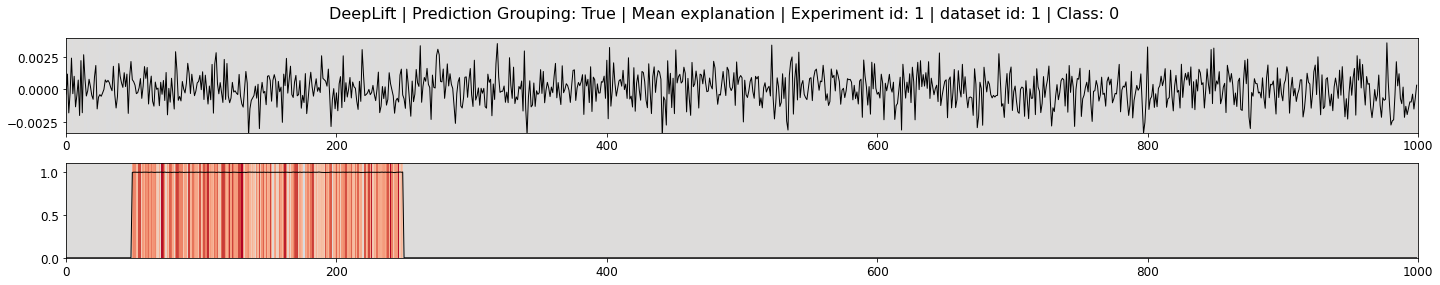

--------------------------------------------------------------------------------------------------


c:\Users\isimic\Anaconda3\envs\pytorch\lib\site-packages\captum\attr\_core\deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


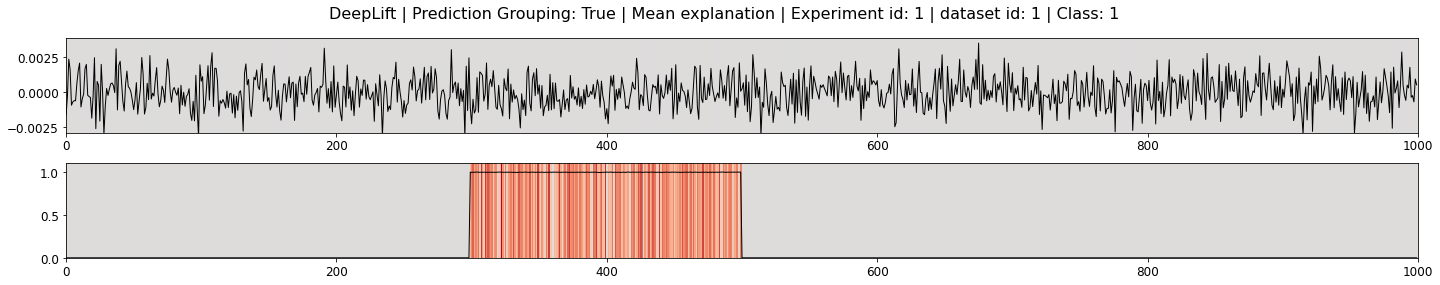

--------------------------------------------------------------------------------------------------


c:\Users\isimic\Anaconda3\envs\pytorch\lib\site-packages\captum\attr\_core\deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


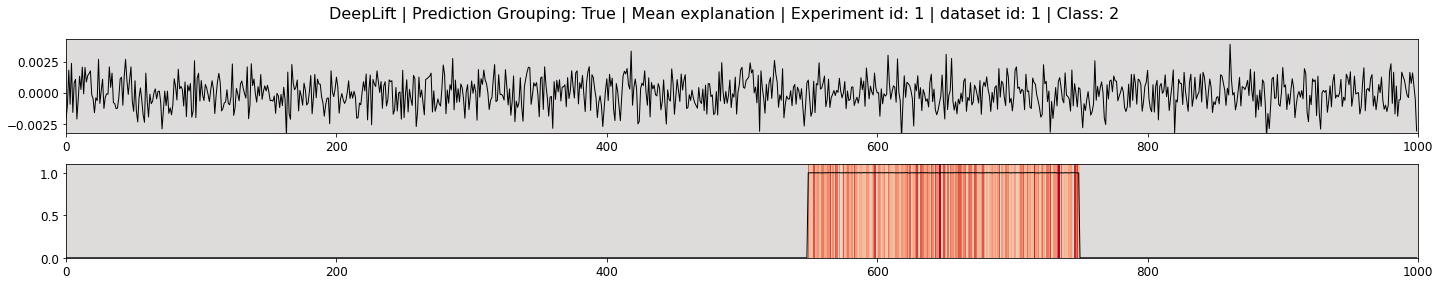

--------------------------------------------------------------------------------------------------
Model accuracy:  1.0


In [51]:
torch.backends.cudnn.enabled=False
# explainer = InputXGradient(model)
explainer = DeepLift(model)
# explainer = IntegratedGradients(model)

# os.makedirs('./XAI_results/multivar_study_')

explainer_name = explainer.__class__.__name__

use_prediction_grouping = True

print('Model accuracy: ', model_accuracy)

for target_class in range(n_classes):
    if use_prediction_grouping :
        class_subset = all_samples[predicted_classes == target_class]
    else:
        class_subset = all_samples[labels == target_class]
    if len(class_subset) == 0:
        print(f'no samples for target class {target_class}')
        continue

    explanations = explainer.attribute(class_subset, target=target_class).cpu().detach().numpy()
    mean_explanation = explanations.mean(axis=0).transpose()
    max_explanation = explanations.max(axis=0).transpose()
    mean_ts = class_subset.mean(axis=0).cpu().detach().numpy().transpose()

    plot_timeseries_with_explanation(mean_ts, mean_explanation, title=f'{explainer_name} | Prediction Grouping: {use_prediction_grouping} | Mean explanation | Experiment id: {experiment_id} | dataset id: {dataset_id} | Class: {target_class}')
    plt.show()

    # plot_timeseries_with_explanation(mean_ts, max_explanation, title=f'{explainer_name} | Prediction Grouping: {use_prediction_grouping} | Max explanation | Experiment id: {experiment_id} | dataset id: {dataset_id} | Class: {target_class}')
    # plt.show()
    print('--------------------------------------------------------------------------------------------------')
print('Model accuracy: ', model_accuracy)

## Alternate visualization over all models

c:\Users\isimic\Anaconda3\envs\pytorch\lib\site-packages\captum\attr\_core\deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


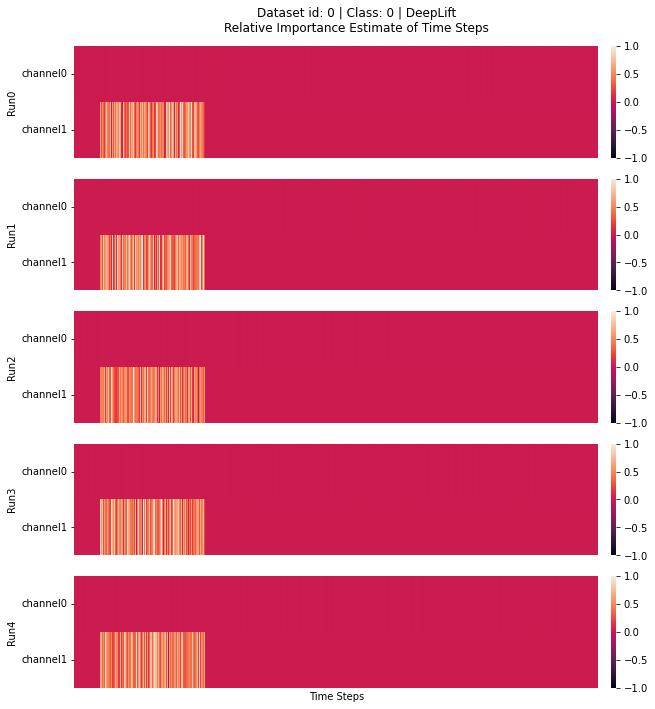

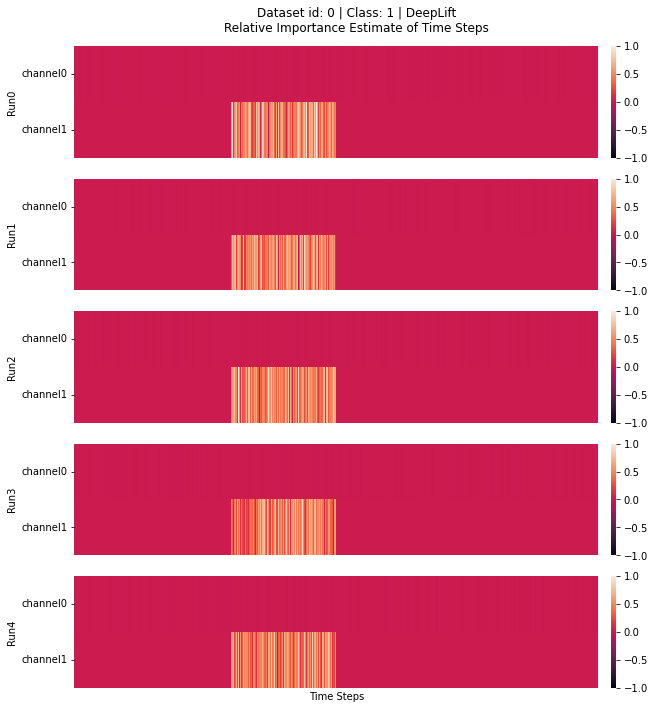

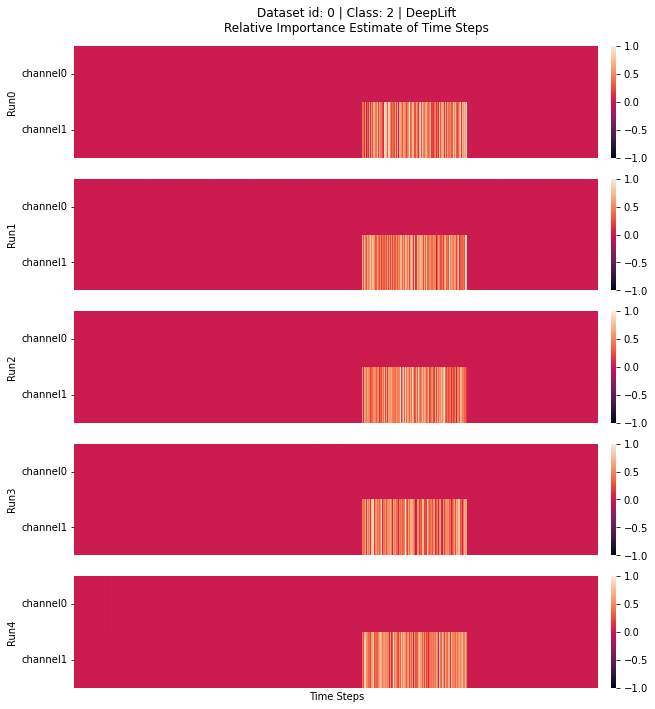

In [52]:
import Models.multi_models as Models
import Models.model_func as Model_Func
from Models.SimulationStudyBaseline_Model import MultivariateSimulationStudyBaseline_Model

n_runs = 5

xai_plots_savepath = 'xai_plots'

target_classes = [0,1,2]
for target_class in target_classes:
    class_subset = all_samples[labels == target_class]

    run_mean_explanations = []

    for run_id in range(n_runs):
        # load model
        baseline_model= MultivariateSimulationStudyBaseline_Model(device=device, input_dim=timeseries.shape[1:], classes=n_classes).to(device)
        model= Models.Multivariate_IEGradient(device=device, input_dim=timeseries.shape[1:],
                                            model=baseline_model).to(device)

        state_dict_path = f'experiments/multisimul_study/exp_log{run_id}/Grad/state_dict/multivarsimul_study{dataset_id}-Grad-state_dict-50.pt'

        state_dict = torch.load(state_dict_path)
        model.load_state_dict(state_dict, strict=True)
        model.eval()

        # initialize explainer and generate mean explanation
        torch.backends.cudnn.enabled=False
        explainer = DeepLift(model)
        explainer_name = explainer.__class__.__name__

        explanations = explainer.attribute(class_subset, target=target_class).cpu().detach().numpy()
        mean_explanation = explanations.mean(axis=0).transpose()
        max_explanation = explanations.max(axis=0).transpose()
        mean_ts = class_subset.mean(axis=0).cpu().detach().numpy().transpose()

        # plot_timeseries_with_explanation(mean_ts, mean_explanation, title=f'Mean explanation | Experiment id: {experiment_id} | dataset id: {dataset_id} | Class: {target_class}')
        # plt.show()

        # plot_timeseries_with_explanation(mean_ts, max_explanation, title=f'Max explanation | Experiment id: {experiment_id} | dataset id: {dataset_id} | Class: {target_class}')
        # plt.show()
        run_mean_explanations.append(mean_explanation)

    # run_mean_explanations = np.array(run_mean_explanations)
    

    # x_labels=  [f"channel{i}" for i in range(class_subset.shape[1])]
    # y_labels= [f"run{i}" for i in range(n_runs)]
    # plt.figure(figsize=(17,6))
    # sns.heatmap(run_mean_explanations, xticklabels="auto", yticklabels=y_labels,annot=False, cbar_kws={"pad":0.02})
    # plt.xlabel("Time Steps")
    # plt.title(f"Dataset id: {dataset_id} | Class: {target_class} | {explainer_name}\nRelative Importance Estimate of Time Steps")
    # plt.tight_layout()

    # # save plots
    # plot_save_path = os.path.join(xai_plots_savepath,'unisimul_study', f'dataset{dataset_id}') # , f'class_{target_class}_{explainer_name}'
    # os.makedirs(plot_save_path, exist_ok=True)
    # plt.savefig(os.path.join(plot_save_path, f'class_{target_class}_{explainer_name}.png'), facecolor='white')
    
    # plt.show()


    fig, axs= plt.subplots(n_runs,1)

    for run_id in range(n_runs):
        run_expl = run_mean_explanations[run_id]
        extent = max(abs(run_expl.min()),abs(run_expl.max()))
        run_expl /= extent
        sns.heatmap(run_expl, xticklabels=False, yticklabels=[f"channel{c}" for c in range(run_expl.shape[0])], annot=False, ax=axs[run_id], cbar_kws={"pad":0.02}, vmin=-1, vmax=1)
        axs[run_id].set_ylabel(f"Run{run_id}")
    
    plt.xlabel("Time Steps")
    plt.suptitle(f"Dataset id: {dataset_id-1} | Class: {target_class} | {explainer_name}\nRelative Importance Estimate of Time Steps")
    fig.set_figwidth(10)
    fig.set_figheight(10)
    plt.tight_layout()

    plot_save_path = os.path.join(xai_plots_savepath,'multivarsimul_study', f'dataset{dataset_id-1}') # , f'class_{target_class}_{explainer_name}'
    os.makedirs(plot_save_path, exist_ok=True)
    plt.savefig(os.path.join(plot_save_path, f'class_{target_class}_{explainer_name}.png'), facecolor='white')

    plt.show()

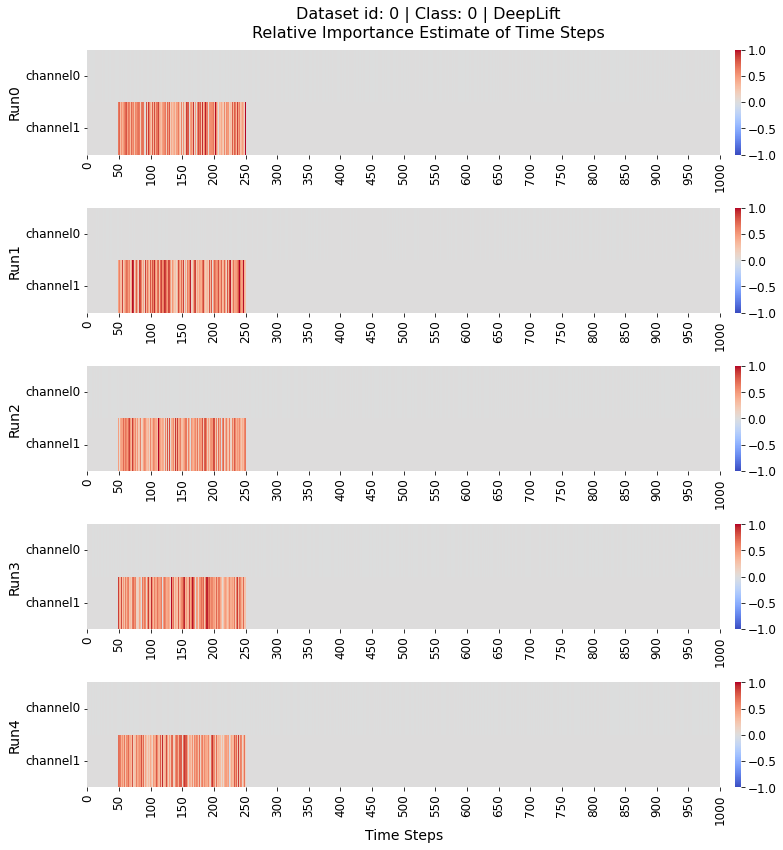

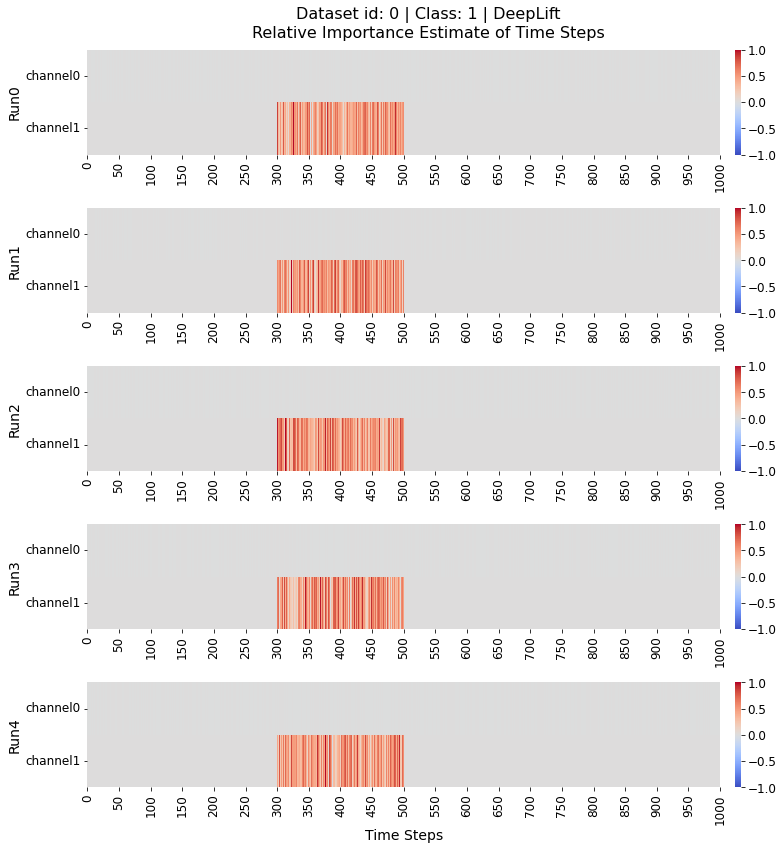

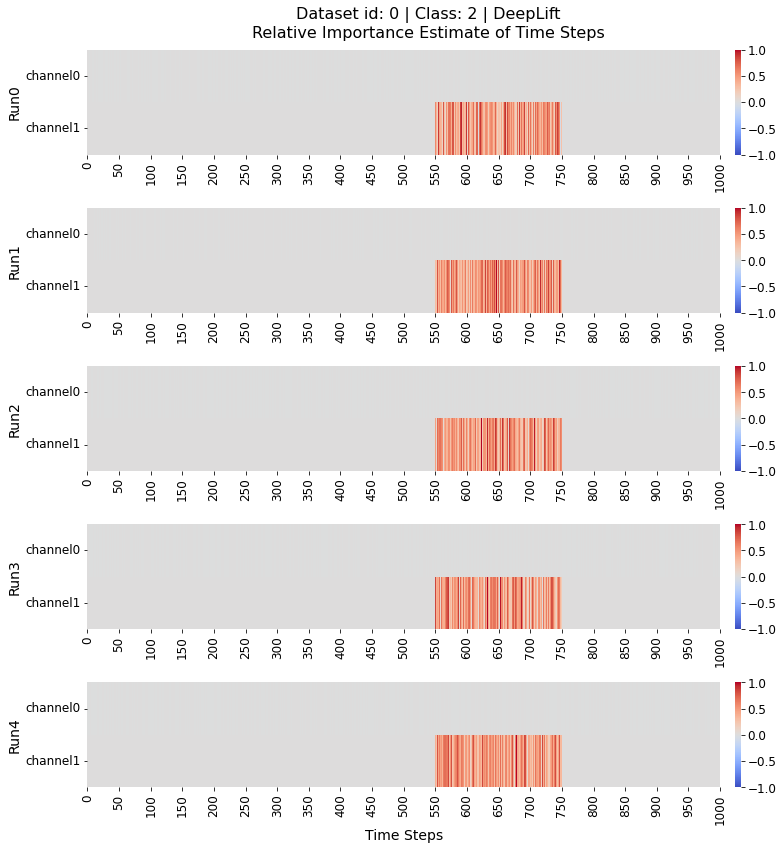

In [58]:
import Models.multi_models as Models
import Models.model_func as Model_Func
from Models.SimulationStudyBaseline_Model import MultivariateSimulationStudyBaseline_Model

n_runs = 5

xai_plots_savepath = 'xai_plots_coolwarm'

target_classes = [0,1,2]
for target_class in target_classes:
    class_subset = all_samples[labels == target_class]

    run_mean_explanations = []

    for run_id in range(n_runs):
        # load model
        baseline_model= MultivariateSimulationStudyBaseline_Model(device=device, input_dim=timeseries.shape[1:], classes=n_classes).to(device)
        model= Models.Multivariate_IEGradient(device=device, input_dim=timeseries.shape[1:],
                                            model=baseline_model).to(device)

        state_dict_path = f'experiments/multisimul_study/exp_log{run_id}/Grad/state_dict/multivarsimul_study{dataset_id}-Grad-state_dict-50.pt'

        state_dict = torch.load(state_dict_path)
        model.load_state_dict(state_dict, strict=True)
        model.eval()

        # initialize explainer and generate mean explanation
        torch.backends.cudnn.enabled=False
        explainer = DeepLift(model)
        explainer_name = explainer.__class__.__name__

        explanations = explainer.attribute(class_subset, target=target_class).cpu().detach().numpy()
        mean_explanation = explanations.mean(axis=0).transpose()
        max_explanation = explanations.max(axis=0).transpose()
        mean_ts = class_subset.mean(axis=0).cpu().detach().numpy().transpose()

        # plot_timeseries_with_explanation(mean_ts, mean_explanation, title=f'Mean explanation | Experiment id: {experiment_id} | dataset id: {dataset_id} | Class: {target_class}')
        # plt.show()

        # plot_timeseries_with_explanation(mean_ts, max_explanation, title=f'Max explanation | Experiment id: {experiment_id} | dataset id: {dataset_id} | Class: {target_class}')
        # plt.show()
        run_mean_explanations.append(mean_explanation)

    # run_mean_explanations = np.array(run_mean_explanations)
    

    # x_labels=  [f"channel{i}" for i in range(class_subset.shape[1])]
    # y_labels= [f"run{i}" for i in range(n_runs)]
    # plt.figure(figsize=(17,6))
    # sns.heatmap(run_mean_explanations, xticklabels="auto", yticklabels=y_labels,annot=False, cbar_kws={"pad":0.02})
    # plt.xlabel("Time Steps")
    # plt.title(f"Dataset id: {dataset_id} | Class: {target_class} | {explainer_name}\nRelative Importance Estimate of Time Steps")
    # plt.tight_layout()

    # # save plots
    # plot_save_path = os.path.join(xai_plots_savepath,'unisimul_study', f'dataset{dataset_id}') # , f'class_{target_class}_{explainer_name}'
    # os.makedirs(plot_save_path, exist_ok=True)
    # plt.savefig(os.path.join(plot_save_path, f'class_{target_class}_{explainer_name}.png'), facecolor='white')
    
    # plt.show()


    fig, axs= plt.subplots(n_runs,1)

    for run_id in range(n_runs):
        run_expl = run_mean_explanations[run_id]
        extent = max(abs(run_expl.min()),abs(run_expl.max()))
        run_expl /= extent
        heatmap = sns.heatmap(run_expl, yticklabels=[f"channel{c}" for c in range(run_expl.shape[0])], annot=False, ax=axs[run_id], cbar_kws={"pad":0.02}, cmap='coolwarm', vmin=-1, vmax=1 )
        axs[run_id].set_ylabel(f"Run{run_id}", fontsize=14)
        axs[run_id].set_xticks(np.arange(0, run_expl.shape[-1]+1, 50),np.arange(0, run_expl.shape[-1]+1, 50), fontsize=12)
        plt.setp(heatmap.get_yticklabels(), fontsize=12)
        colorbar = heatmap.collections[0].colorbar
        colorbar.ax.tick_params(labelsize=12)


    plt.xlabel("Time Steps", fontsize=14)
    plt.suptitle(f"Dataset id: {dataset_id-1} | Class: {target_class} | {explainer_name}\nRelative Importance Estimate of Time Steps", fontsize=16)
    fig.set_figwidth(12)
    fig.set_figheight(12)
    plt.tight_layout()

    plot_save_path = os.path.join(xai_plots_savepath,'multivarsimul_study', f'dataset{dataset_id-1}') # , f'class_{target_class}_{explainer_name}'
    os.makedirs(plot_save_path, exist_ok=True)
    plt.savefig(os.path.join(plot_save_path, f'class_{target_class}_{explainer_name}.png'), facecolor='white')

    plt.show()